# 520556528 + 530101303

# Import Libs

In [161]:
import numpy as np
import time
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load Datasets

In [162]:
file_path = './Assignment1-Dataset/'

train_X = np.load(file_path + 'train_data.npy')
train_y = np.load(file_path + 'train_label.npy')
test_X = np.load(file_path + 'test_data.npy')
test_y = np.load(file_path + 'test_label.npy')

In [163]:
print(f'Number of samples of train set: {train_X.shape[0]}.')
print(f'Number of features: {train_X.shape[1]}.')

Number of samples of train set: 50000.
Number of features: 128.


In [164]:
print(f'Number of class: {np.unique(train_y).shape[0]}.')
print(f'All classes: {np.unique(train_y)}')

Number of class: 10.
All classes: [0 1 2 3 4 5 6 7 8 9]


# Utils

## Timer

A decorator for recording training time.

In [165]:
def timer(func):
    def wrapper(*args, **kwargs):
        print('Start time: ', time.ctime())
        start_time = time.time()  # start time

        result = func(*args, **kwargs)  # run

        end_time = time.time()  # end time
        print('End time: ', time.ctime())
        print(f"{func.__name__} executed in {(end_time - start_time):.4f} seconds")
        return result
    return wrapper

@timer
def test_fun(x):
    time.sleep(x)

test_fun(1)

Start time:  Sun Apr  7 21:30:38 2024
End time:  Sun Apr  7 21:30:39 2024
test_fun executed in 1.0051 seconds


## Kaiming Init

Refer from https://github.com/pytorch/pytorch/blob/main/torch/nn/init.py.

Modify tensor to np.array

In [166]:
def calculate_gain(nonlinearity, param=None):
    r"""Return the recommended gain value for the given nonlinearity function.
    The values are as follows:

    ================= ====================================================
    nonlinearity      gain
    ================= ====================================================
    Linear / Identity :math:`1`
    Conv{1,2,3}D      :math:`1`
    Sigmoid           :math:`1`
    Tanh              :math:`\frac{5}{3}`
    ReLU              :math:`\sqrt{2}`
    Leaky Relu        :math:`\sqrt{\frac{2}{1 + \text{negative\_slope}^2}}`
    SELU              :math:`\frac{3}{4}`
    ================= ====================================================
    """
    
    if nonlinearity == 'sigmoid':
        return 1
    elif nonlinearity == 'tanh':
        return 5.0 / 3
    elif nonlinearity == 'relu':
        return math.sqrt(2.0)
    elif nonlinearity == 'leaky_relu':
        if param is None:
            negative_slope = 0.01
        elif not isinstance(param, bool) and isinstance(param, int) or isinstance(param, float):
            # True/False are instances of int, hence check above
            negative_slope = param
        else:
            raise ValueError(f"negative_slope {param} not a valid number")
        return math.sqrt(2.0 / (1 + negative_slope ** 2))
    elif nonlinearity == 'selu':
        return 3.0 / 4  # Value found empirically (https://github.com/pytorch/pytorch/pull/50664)
    else:
        raise ValueError(f"Unsupported nonlinearity {nonlinearity}")

def _calculate_fan_in_and_fan_out(array):
    dimensions = len(array.shape)
    if dimensions < 2:
        raise ValueError("Fan in and fan out can not be computed for tensor with fewer than 2 dimensions")

    num_input_fmaps = array.shape[1]
    num_output_fmaps = array.shape[0]
    receptive_field_size = 1
    if dimensions > 2:
        # math.prod is not always available, accumulate the product manually
        # we could use functools.reduce but that is not supported by TorchScript
        for s in array.shape[2:]:
            receptive_field_size *= s
    fan_in = num_input_fmaps * receptive_field_size
    fan_out = num_output_fmaps * receptive_field_size

    return fan_in, fan_out

def _calculate_correct_fan(array, mode):
    mode = mode.lower()
    valid_modes = ['fan_in', 'fan_out']
    if mode not in valid_modes:
        raise ValueError(f"Mode {mode} not supported, please use one of {valid_modes}")

    fan_in, fan_out = _calculate_fan_in_and_fan_out(array)
    return fan_in if mode == 'fan_in' else fan_out

def kaiming_normal_(array: np.array, a: float = 0, mode: str = 'fan_in', nonlinearity: str = 'relu'):
    fan = _calculate_correct_fan(array, mode)
    gain = calculate_gain(nonlinearity, a)
    std = gain / math.sqrt(fan)
    return np.random.normal(0, std, array.shape)

## Parameter

In [167]:
class Parameter(object):
    """Parameter class for saving data and gradients"""
    def __init__(self, data, requires_grad, skip_decay=False):
        self.data = data
        self.grad = None
        self.skip_decay = skip_decay
        self.requires_grad = requires_grad

## AverageMeter

In [168]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Accuracy

In [169]:
def accuracy(output, target):
    """
        output: [batch_size, num_of_class]
        target: [batch_size, 1]
    """
    preds = output.argmax(axis=-1, keepdims=True)
    return np.mean(preds == target) * 100

## Pre-process

Min-max normalization:

$$x_{min-max} = {{x-min(x)}\over{max(x)-min(x)}}$$

Standardization:

$$x_{norm} = {{x-\mu}\over{\sigma}}$$

In [170]:
def get_transform(train_X, test_X, mode=None):
    if mode == 'min-max':
        print('Pre-process: min-max normalization')
        min_each_feature = np.min(train_X, axis=0)
        max_each_feature = np.max(train_X, axis=0)
        scale = max_each_feature - min_each_feature
        scale[scale == 0] = 1   # To avoid divided by 0
        scaled_train = (train_X - min_each_feature) / scale
        scaled_test = (test_X - min_each_feature) / scale
        return scaled_train, scaled_test

    if mode == 'standardization':  
        print('Pre-process: standardization')
        std_each_feature = np.std(train_X, axis=0)
        mean_each_feature = np.mean(train_X, axis=0)
        std_each_feature[std_each_feature == 0] = 1     # To avoid divided by 0
        norm_train = (train_X - mean_each_feature) / std_each_feature
        norm_test = (test_X - mean_each_feature) / std_each_feature
        return norm_train, norm_test
    
    print('No pre-process')

    return train_X, test_X

# Layers

## Base layer

In [171]:
class Layer(object):
    def __init__(self, name, requires_grad=False):
        self.name = name 
        self.requires_grad = requires_grad
        
    def forward(self, *args):
        pass

    def backward(self, *args):
        pass

## Activation

### Relu

Forward:
$$f(x) = \max(0, x)$$ 

Backward:

$$f'(x) = \begin{cases} 
1 & \text{if } x > 0 \\
0 & \text{if } x \leq 0 
\end{cases}$$

In [172]:
class relu(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)

    def forward(self, input):
        self.input = input
        return np.maximum(0, input)
    
    def backward(self, grad_output):
        grad_output[self.input <= 0] = 0
        return grad_output

### Leaky Relu

Forward:

$$f(x) = \begin{cases} 
x & \text{if } x > 0 \\
\alpha x & \text{if } x \leq 0 
\end{cases}$$

Backward:

$$f'(x) = \begin{cases} 
1 & \text{if } x > 0 \\
\alpha & \text{if } x \leq 0 
\end{cases}
$$

In [173]:
class leaky_relu(Layer):
    def __init__(self, name, alpha, requires_grad=False):
        super().__init__(name, requires_grad)
        self.alpha = alpha

    def forward(self, input):
        self.input = input
        return np.where(input > 0, input, self.alpha * input)
    
    def backward(self, grad_output):
        tmp = np.where(self.input > 0, 1, self.alpha)
        return tmp * grad_output

### Sigmoid

Forward:

$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

Backward:

$$\sigma'(x) = \sigma(x)(1 - \sigma(x))$$

In [207]:
class sigmoid(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)
        
    def forward(self, input):
        self.y = 1. / (1. + np.exp(-input))
        return self.y
    
    def backward(self, grad_output):
        return self.y * (1 - self.y) * grad_output

### Tanh

Forward:

$$\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}$$

Backward:

$$\tanh'(x) = 1 - \tanh^2(x)$$

In [175]:
class tanh(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)

    def forward(self, input):
        self.y = np.tanh(input)
        return np.tanh(input)
    
    def backward(self, grad_output):
        return (1 - self.y ** 2) * grad_output

### Softmax 

Forward:

$$softmax(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

In [176]:
class softmax(Layer):
    def __init__(self, name, requires_grad=False):
        super().__init__(name, requires_grad)
        
    def forward(self, input):
        x_max = input.max(axis=-1, keepdims=True)       # to avoid overflow
        x_exp = np.exp(input - x_max)
        return x_exp / x_exp.sum(axis=-1, keepdims=True)
    
    def backward(self, grad_output):
        # packaged in CrossEntropyLoss for more convenient grad computation
        return grad_output

## Hidden layer

Forward:

$$\mathbf{y} = \mathbf{xW} + \mathbf{b}$$


Backward:

$$\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{x}}$$

$$\frac{\partial L}{\partial \mathbf{x}} = \frac{\partial L}{\partial \mathbf{y}} \mathbf{W}^T$$

Gradient of W:

$$\frac{\partial L}{\partial \mathbf{W}} = \frac{\partial L}{\partial \mathbf{y}} \frac{\partial \mathbf{y}}{\partial \mathbf{W}}$$

$$\frac{\partial L}{\partial \mathbf{W}} = \frac{\partial L}{\partial \mathbf{y}} \mathbf{x}^T$$

Gradient of b:

$$\frac{\partial L}{\partial \mathbf{b}} = \frac{\partial L}{\partial \mathbf{y}} $$

In [177]:
class HiddenLayer(Layer):
    def __init__(self, name, in_num, out_num):
        super().__init__(name, requires_grad=True)
        self.in_num = in_num
        self.out_num = out_num

        W = kaiming_normal_(np.array([0] * in_num * out_num).reshape(in_num, out_num), a=math.sqrt(5))
        self.W = Parameter(W, self.requires_grad)
        self.b = Parameter(np.zeros(out_num), self.requires_grad)

    def forward(self, input):
        """
            input: [batch size, in_num]
            W: [in_num, out_num]
            b: [out_num]
        """
        self.input = input
        return input @ self.W.data + self.b.data      # [batch size, in_num] @ [in_num, out_num] + [out_num] => [batch size, out_num]
    
    def backward(self, grad_output):
        """
            grad_output: [batch size, out_num]
        """
        batch_size = grad_output.shape[0]
        self.W.grad = self.input.T @ grad_output / batch_size   # [in_num, batch size] @ [batch size, out_num] => [in_num, out_num], 
        self.b.grad = grad_output.sum(axis=0) / batch_size      # here divided by batch size to compute avg of gradient
        return grad_output @ self.W.data.T

# Loss Function

Cross Entropy

Formula:

$$CrossEntropy = -\sum_{i=1}^{n} y_i \log(\hat{y}_i)$$

Gradient of softmax:

$$\frac{\partial L}{\partial z_k} = \sum_{i}^{d} \left( \frac{\partial L}{\partial \hat{y}_i} \frac{\partial \hat{y}_i}{\partial z_k} \right)$$

$$\frac{\partial L}{\partial \hat{y}_i} = - \frac{y_i}{\hat{y}_i}, \qquad \frac{\partial \hat{y}_i}{\partial z_k} = \begin{cases} 
\hat{y}_i(1 - \hat{y}_i) & \text{if } i = k \\
-\hat{y}_k\hat{y}_i & \text{if } i \neq k 
\end{cases}
$$

$$\frac{\partial L}{\partial z_k} = - \left( (y_k(1 - \hat{y}_k)) - \sum_{i \neq k}^{d} y_i \hat{y}_k \right) = -(y_k - \hat{y}_k \sum_{i}^{d} y_i) = \hat{y}_k - y_k
$$

$$=> \frac{\partial L}{\partial z} = \hat{y} - y$$

In [178]:
class CrossEntropyLoss(object):
    def __init__(self):
        self.softmax = softmax('softmax')

    def __call__(self, input, ground_truth):
        self.bacth_size = input.shape[0]
        self.class_num = input.shape[1]

        preds = self.softmax.forward(input)
        ground_truth = self.one_hot_encoding(ground_truth)

        self.grad = preds - ground_truth

        loss = -1 * (ground_truth * np.log(preds + 1e-8)).sum() / self.bacth_size   # to avoid divided by 0

        return loss
    
    def one_hot_encoding(self, x):
        one_hot_encoded = np.zeros((self.bacth_size, self.class_num))
        one_hot_encoded[np.arange(x.size), x.flatten()] = 1
        return one_hot_encoded

# BatchNorm

In [179]:
class batchnorm(Layer):
    def __init__(self, name, shape, requires_grad=True):
        super().__init__(name)
        self.gamma = Parameter(np.random.uniform(0.9, 1.1, shape), requires_grad, skip_decay=True)
        self.beta = Parameter(np.random.uniform(-0.1, 0.1, shape), requires_grad, skip_decay=True)
        self.requires_grad = requires_grad

        self.running_mean = Parameter(np.zeros(shape), False)
        self.running_var = Parameter(np.zeros(shape), False)

    
    def forward(self, input):
        if self.train:
            batch_mean = input.mean(axis=0)
            batch_var = input.var(axis=0)
            batch_std = np.sqrt(batch_var + 1e-8)    # To avoid divided by 0

            momentum = 0.9
            self.running_mean.data = momentum * self.running_mean.data + (1 - momentum) * batch_mean
            self.running_var.data = momentum * self.running_var.data + (1 - momentum) * batch_var
            
        
        else:
            batch_mean = self.running_mean.data
            batch_std = np.sqrt(self.running_var.data)

        self.norm = (input - batch_mean) / batch_std
        self.gamma_norm = self.gamma.data / batch_std

        return self.gamma.data * self.norm + self.beta.data
        
    
    def backward(self, grad_output):        
        batch_size = grad_output.shape[0]
        self.gamma.grad = (grad_output * self.norm).sum(axis=0) / batch_size
        self.beta.grad = grad_output.sum(axis=0) / batch_size
        return self.gamma_norm * (grad_output - self.norm * self.gamma.grad - self.beta.grad)

# Dropout

In [180]:
class dropout(Layer):
    def __init__(self, name, drop_rate, requires_grad=False):
        super().__init__(name, requires_grad)
        self.drop_rate = drop_rate
        self.fix_value = 1 / (1 - self.drop_rate)   # to keep average fixed

    def forward(self, input):
        if self.train:
            self.mask = np.random.uniform(0, 1, input.shape) > self.drop_rate
            return input * self.mask * self.fix_value
        else:
            return input

    def backward(self, grad_output):
        if self.train:
            return grad_output * self.mask
        else:
            return grad_output

# MLP

In [181]:
class MLP(object):
    def __init__(self):
        self.layers = []
        self.params = []
        self.num_layers = 0
    
    def add_layer(self, layer):
        self.layers.append(layer)
        if layer.requires_grad:
            if hasattr(layer, 'W'):
                self.params.append(layer.W)
            if hasattr(layer, 'b'):
                self.params.append(layer.b)
            if hasattr(layer, 'gamma'):
                self.params.append(layer.gamma)
            if hasattr(layer, 'beta'):
                self.params.append(layer.beta)
        self.num_layers += 1

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, x):
        for layer in self.layers[::-1]:
            x = layer.backward(x)
        return x
    
    def train(self):
        for layer in self.layers:
            layer.train = True
    
    def test(self):
        for layer in self.layers:
            layer.train = False

# Optimizer

## SGD with Momentum

Formula:

$$v_t = \beta v_{t-1} + \alpha g_t$$

$$\theta_t = \theta_{t-1} - v_t$$

where $\alpha$ is the learning rate, $\beta$ is the momentum term.

In [182]:
class SGD(object):
    def __init__(self, parameters, momentum, lr, weight_decay):
        self.parameters = parameters
        self.momentum = momentum
        self.lr = lr
        self.weight_decay = weight_decay
        self.v = [np.zeros(p.data.shape) for p in self.parameters]

    def step(self):
        for i, (v, p) in enumerate(zip(self.v, self.parameters)):
            if not p.skip_decay:
                p.data -= self.weight_decay * p.data
            v = self.momentum * v + self.lr * p.grad
            self.v[i] = v
            p.data -= self.v[i]

## Adam

Formula:

$$m_t = \beta_1 m_{t-1} + (1 - \beta_1) g_t$$

$$v_t = \beta_2 v_{t-1} + (1 - \beta_2) g_t^2$$

bias correction: $\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$, $\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$

$$\theta_t = \theta_{t-1} - \alpha \cdot \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}$$

In [183]:
class Adam(object):
    def __init__(self, parameters, lr, weight_decay=0, beta=(0.9, 0.999), eps=1e-8):
        self.beta1 = beta[0]
        self.beta2 = beta[1]
        self.lr = lr
        self.weight_decay = weight_decay
        self.eps = eps
        self.parameters = parameters
        self.m = [np.zeros(p.data.shape) for p in self.parameters]
        self.v = [np.zeros(p.data.shape) for p in self.parameters]
        self.iterations = 0
    
    def step(self):
        self.iterations += 1
        for i, (p, m, v) in enumerate(zip(self.parameters, self.m, self.v)):
            if not p.skip_decay:
                p.data -= self.weight_decay * p.data
            m = self.beta1 * m + (1 - self.beta1) * p.grad
            v = self.beta2 * v + (1 - self.beta2) * np.power(p.grad, 2)

            self.m[i] = m
            self.v[i] = v
            
            # bias correction
            m = m / (1 - np.power(self.beta1, self.iterations))
            v = v / (1 - np.power(self.beta2, self.iterations))

            p.data -= self.lr * m / (np.sqrt(v + self.eps))

# Scheduler

## Cosine Annealing Learning Rate

Formula:

$$\eta_t = \frac{1}{2}\eta_{\text{base}} (1 + \cos(\frac{T_{\text{cur}}}{T_{\max}}\pi))$$

In [184]:
class CosineLR(object):
    def __init__(self, optimizer, T_max):
        self.optimizer = optimizer
        self.T_max = T_max
        self.n = -1
        self.base_lr = optimizer.lr
        self.step()

    def step(self):
        self.n += 1
        lr = self.get_lr()
        self.optimizer.lr = lr

    def get_lr(self):
        cos = np.cos(np.pi * self.n / self.T_max)
        return self.base_lr * (1 + cos) / 2

# Trainer

In [185]:
class Trainer(object):
    def __init__(self, config, model=None, train_loader=None, val_loader=None):
        self.config = config
        self.epochs = self.config['epoch']
        self.lr = self.config['lr']
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.print_freq = self.config['print_freq']
        self.scheduler = self.config['scheduler']
        self.train_precs = []
        self.test_precs = []
        self.train_losses = []
        self.test_losses = []

        self.criterion = CrossEntropyLoss()
        if self.config['optimizer'] == 'sgd':
            self.optimizer = SGD(self.model.params, self.config['momentum'], self.lr, self.config['weight_decay'])
        elif self.config['optimizer'] == 'adam':
            self.optimizer = Adam(self.model.params, self.lr, self.config['weight_decay'])
        if self.scheduler == 'cos':
            self.train_scheduler = CosineLR(self.optimizer, T_max=self.epochs)

    @timer
    def train(self):
        best_acc1 = 0
        for epoch in range(self.epochs):
            print('current lr {:.5e}'.format(self.optimizer.lr))
            self.train_per_epoch(epoch)
            if self.scheduler == 'cos':
                self.train_scheduler.step()

            # evaluate on validation set
            acc1 = self.validate(epoch)

            # remember best prec@1
            best_acc1 = max(acc1, best_acc1)
            output_best = 'Best Prec@1: %.3f\n' % (best_acc1)
            print(output_best)

    
    def train_per_epoch(self, epoch):
        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()

        self.model.train()

        end = time.time()

        for i, (input, target) in enumerate(self.train_loader):
            # compute output
            output = self.model.forward(input)
            loss = self.criterion(output, target)

            # compute gradient and step
            self.model.backward(self.criterion.grad)
            self.optimizer.step()

            # measure accuracy and record loss
            prec1 = accuracy(output, target)
            losses.update(loss, input.shape[0])
            top1.update(prec1, input.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i % self.print_freq == 0) or (i == len(self.train_loader) - 1):
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                        epoch + 1, i, len(self.train_loader) - 1, batch_time=batch_time,
                        loss=losses, top1=top1))
        
        output = ('EPOCH: {epoch} {flag} Results: Prec@1 {top1.avg:.3f} Loss: {losses.avg:.4f}'.format(epoch=epoch + 1 , flag='train', top1=top1, losses=losses))
        print(output)
        self.train_losses.append(losses.avg)
        self.train_precs.append(top1.avg)
                
    def validate(self, epoch):
        batch_time = AverageMeter()
        losses = AverageMeter()
        top1 = AverageMeter()

        self.model.test()

        end = time.time()
        for i, (input, target) in enumerate(self.val_loader):
            # compute output
            output = self.model.forward(input)
            loss = self.criterion(output, target)

            # measure accuracy and record loss
            prec1 = accuracy(output, target)
            losses.update(loss, input.shape[0])
            top1.update(prec1, input.shape[0])

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if (i % self.print_freq == 0) or (i == len(self.val_loader) - 1):
                print('Test: [{0}/{1}]\t'
                    'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                    'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                    'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                        i, len(self.val_loader) - 1, batch_time=batch_time, loss=losses,
                        top1=top1))
        
        output = ('EPOCH: {epoch} {flag} Results: Prec@1 {top1.avg:.3f} Loss: {losses.avg:.4f}'.format(epoch=epoch + 1 , flag='val', top1=top1, losses=losses))
        print(output)
        self.test_losses.append(losses.avg)
        self.test_precs.append(top1.avg)

        return top1.avg
    
    def plot_cm(self, save_path):
        self.model.test()
        y_pred = []
        y_true = []
        for i, (input, target) in enumerate(self.val_loader):
            # compute output
            output = self.model.forward(input)
            output = np.argmax(output, axis=1)
            y_pred += list(output)
            y_true += list(target.flatten())
            
        cm = confusion_matrix(y_true, y_pred)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.ylabel("Ground Truth")
        plt.xlabel("Prediction")
        plt.savefig(save_path)
        


# Dataloader

In [186]:
class Dataloader(object):
    def __init__(self, X, y, batch_size, shuffle=True, seed=None):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.index = np.arange(X.shape[0])
    
    def __iter__(self):
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.index)
        self.n = 0
        return self
    
    def __next__(self):
        if self.n >= len(self.index):
            raise StopIteration
        
        index = self.index[self.n:self.n + self.batch_size]
        batch_X = self.X[index]
        batch_y = self.y[index]
        self.n += self.batch_size

        return batch_X, batch_y
    
    def __len__(self):
        """
            num of batch
        """
        return (len(self.index) + self.batch_size - 1) // self.batch_size  # ceiling

# Main

Configs of Baseline vs Best Model

| Modules                | Baseline          | Best Model        |
| ---------------------- | ----------------- | ----------------- |
| Batch size             | 128               | 1024              |
| Learning rate          | 0.1               | 0.01              |
| Scheduler              | CosineAnnealingLR | None              |
| Epoch                  | 100               | 200               |
| Pre-processing         | Standardization   | Standardization   |
| Number of Hidden layer | 2                 | 2                 |
| Hidden units           | [64, 32]          | [256, 128]        |
| Activations            | [Relu, Relu]      | [Relu, Relu]      |
| Weight initialisation  | Kaiming           | Kaiming           |
| Weight decay           | 5e-4              | 5e-4              |
| Optimizer              | SGD with Momentum | SGD with Momentum |
| Momentum               | 0.9               | 0.9               |
| Batch Normalisation    | Yes               | Yes               |
| Dropout rate           | 0.1               | 0.3               |
| Accuracy               | 53.03%            | 58.71%            |

## run!

In [191]:
def get_model(layers):
    model = MLP()
    str2obj = {
        'linear': HiddenLayer, 
        'relu': relu, 
        'leaky_relu': leaky_relu,
        'sigmoid': sigmoid, 
        'tanh': tanh,
        'batchnorm': batchnorm,
        'dropout': dropout
    }
    for i in layers:
        model.add_layer(str2obj[i['type']](**i['params']))
    
    return model


layers = [
    {'type': 'linear', 'params': {'name': 'fc1', 'in_num': 128, 'out_num': 256}},
    {'type': 'batchnorm', 'params': {'name': 'bn1', 'shape': 256}}, 
    {'type': 'dropout', 'params': {'name': 'dropout1', 'drop_rate': 0.3}},
    #{'type': 'sigmoid', 'params': {'name': 'sigmoid'}},  
    #{'type': 'leaky_relu', 'params': {'name': 'leaky_relu1', 'alpha': 0.1}},  
    {'type': 'relu', 'params': {'name': 'relu1'}},  
    #{'type': 'tanh', 'params': {'name': 'tanh1'}},  
    {'type': 'linear', 'params': {'name': 'fc2', 'in_num': 256, 'out_num': 128}},
    {'type': 'batchnorm', 'params': {'name': 'bn2', 'shape': 128}}, 
    {'type': 'dropout', 'params': {'name': 'dropout2', 'drop_rate': 0.3}},
    {'type': 'relu', 'params': {'name': 'relu2'}}, 
    {'type': 'linear', 'params': {'name': 'fc3', 'in_num': 128, 'out_num': 10}},
]

bs = 1024
config = {
    'layers': layers,
    'lr': 0.01, 
    'bs': bs,
    'momentum': 0.9,
    'weight_decay': 5e-4,
    'seed': 0,
    'epoch': 200,
    'optimizer': 'sgd',     # adam, sgd
    'scheduler': None,      # cos, None
    'pre-process': 'standardization',      # min-max, standardization, None
    'print_freq': 50000 // bs // 5
}
np.random.seed(config['seed'])

# pre process
train_X, test_X = get_transform(train_X, test_X, config['pre-process'])

train_dataloader = Dataloader(train_X, train_y, config['bs'], shuffle=True, seed=config['seed'])
test_dataloader = Dataloader(test_X, test_y, config['bs'], shuffle=False)
model = get_model(config['layers'])
trainer = Trainer(config, model, train_dataloader, test_dataloader)
trainer.train()

Pre-process: standardization
Start time:  Sun Apr  7 21:38:34 2024
current lr 1.00000e-02
Epoch: [1][0/48]	Time 0.069 (0.069)	Loss 6.3604 (6.3604)	Prec@1 10.059 (10.059)
Epoch: [1][9/48]	Time 0.019 (0.029)	Loss 5.7673 (6.0833)	Prec@1 10.254 (10.771)
Epoch: [1][18/48]	Time 0.049 (0.032)	Loss 4.9681 (5.7364)	Prec@1 13.867 (11.570)
Epoch: [1][27/48]	Time 0.031 (0.030)	Loss 4.5470 (5.4580)	Prec@1 15.723 (12.266)
Epoch: [1][36/48]	Time 0.024 (0.030)	Loss 4.0316 (5.2018)	Prec@1 16.016 (12.962)
Epoch: [1][45/48]	Time 0.024 (0.028)	Loss 3.9700 (4.9673)	Prec@1 17.578 (13.827)
Epoch: [1][48/48]	Time 0.027 (0.029)	Loss 3.9148 (4.9051)	Prec@1 18.986 (14.072)
EPOCH: 1 train Results: Prec@1 14.072 Loss: 4.9051
Test: [0/9]	Time 0.010 (0.010)	Loss 2.5207 (2.5207)	Prec@1 23.438 (23.438)
Test: [9/9]	Time 0.012 (0.012)	Loss 2.4671 (2.4695)	Prec@1 24.235 (24.160)
EPOCH: 1 val Results: Prec@1 24.160 Loss: 2.4695
Best Prec@1: 24.160

current lr 1.00000e-02
Epoch: [2][0/48]	Time 0.034 (0.034)	Loss 3.6886 (3.

# Plot results

## Confusion Matrix

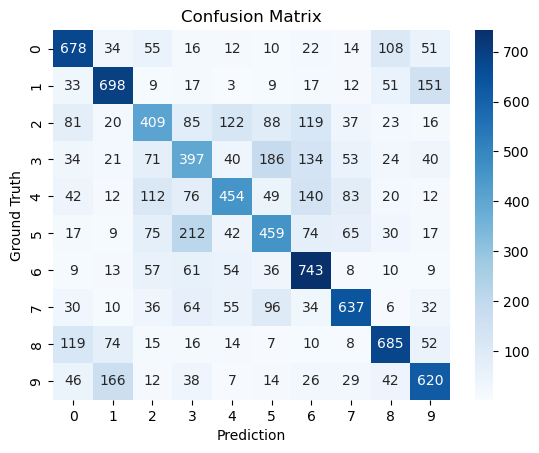

In [188]:
trainer.plot_cm('./figs/cm.png')

## Accuracy

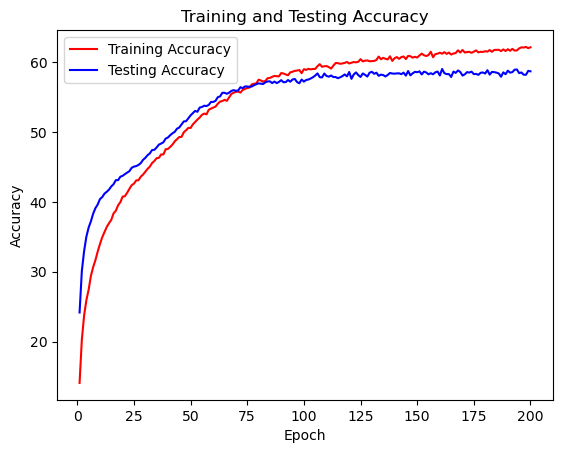

In [202]:
def plot_accuracy(trainer):
    train_accu = trainer.train_precs
    test_accu = trainer.test_precs
    x = [i + 1 for i in range(trainer.epochs)]

    plt.figure()
    plt.plot(x, train_accu, 'r-', label='Training Accuracy')
    plt.plot(x, test_accu, 'b-', label='Testing Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(trainer)

## Loss

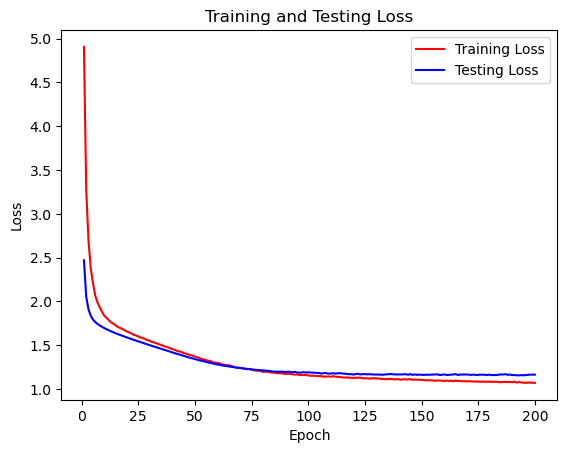

In [197]:
def plot_loss(trainer):
    train_accu = trainer.train_losses
    test_accu = trainer.test_losses
    x = [i + 1 for i in range(trainer.epochs)]

    plt.figure()
    plt.plot(x, train_accu, 'r-', label='Training Loss')
    plt.plot(x, test_accu, 'b-', label='Testing Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(trainer)